In [29]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchsummary
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR100
from torchvision import utils
from torchvision.utils import make_grid

### Dataset

In [7]:
train = CIFAR100(root='./data/', train=True, download=True, transform=transforms.ToTensor())
test = CIFAR100(root='./data/', train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 169M/169M [00:12<00:00, 14.0MB/s] 


Extracting ./data/cifar-100-python.tar.gz to ./data/
Files already downloaded and verified


In [11]:
train_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in train]
test_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in test]

train_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in train]
test_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in test]

print(f'train mean: {np.array(train_meanRGB).shape}')
print(f'train std: {np.array(train_stdRGB).shape}')

print(f'test mean: {np.array(test_meanRGB).shape}')
print(f'test std: {np.array(test_stdRGB).shape}')

train mean: (50000, 3)
train std: (50000, 3)
test mean: (10000, 3)
test std: (10000, 3)


In [17]:
train_meanR = np.mean([m[0] for m in train_meanRGB])
train_meanG = np.mean([m[1] for m in train_meanRGB])
train_meanB = np.mean([m[2] for m in train_meanRGB])

test_meanR = np.mean([m[0] for m in test_meanRGB])
test_meanG = np.mean([m[1] for m in test_meanRGB])
test_meanB = np.mean([m[2] for m in test_meanRGB])

train_stdR = np.std([s[0] for s in train_stdRGB])
train_stdG = np.std([s[1] for s in train_stdRGB])
train_stdB = np.std([s[2] for s in train_stdRGB])

test_stdR = np.std([s[0] for s in test_stdRGB])
test_stdG = np.std([s[1] for s in test_stdRGB])
test_stdB = np.std([s[2] for s in test_stdRGB])

print(f'train mean : {train_meanR, train_meanG, train_meanB}')
print(f'test mean : {test_meanR, test_meanG, test_meanB}')

print(f'train std : {train_stdR, train_stdG, train_stdB}')
print(f'test std : {test_stdR, test_stdG, test_stdB}')

train mean : (np.float32(0.50707513), np.float32(0.48654887), np.float32(0.44091785))
test mean : (np.float32(0.5087964), np.float32(0.48739308), np.float32(0.4419422))
train std : (np.float32(0.0646075), np.float32(0.06354212), np.float32(0.074274234))
test std : (np.float32(0.0643395), np.float32(0.06320942), np.float32(0.07394636))


In [21]:
train_transformer = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=(train_meanR, train_meanG, train_meanB), std=(train_stdR, train_stdG, train_stdB)),
                                       transforms.RandomHorizontalFlip()])

test_transformer = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=(test_meanR, test_meanG, test_meanB), std=(test_stdR, test_stdG, test_stdB)),
                                       transforms.RandomHorizontalFlip()])

train.transform = train_transformer
test.transform = test_transformer

trainloader = DataLoader(train, batch_size=64, shuffle=True)
testloader = DataLoader(test, batch_size=64, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-7.848549..8.080484].


image indices: [ 2732 43567 42613 45891]
torch.Size([3, 228, 906])


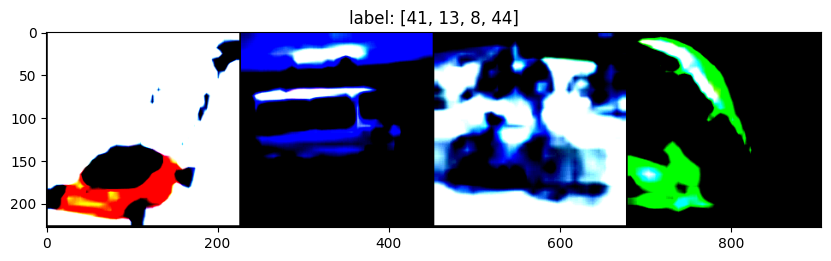

In [33]:
def show(img, y=None, color=True):
    npimg = img.numpy()
    npimg_tr = np.transpose(npimg, (1,2,0))
    plt.imshow(npimg_tr)

    if y is not None:
        plt.title('label: '+ str(y))

np.random.seed(0)
torch.manual_seed(0)

rnd_inds = np.random.randint(0, len(train), 4)
print('image indices:', rnd_inds)

x_grid=[train[i][0] for i in rnd_inds]
y_grid=[train[i][1] for i in rnd_inds]

x_grid = make_grid(x_grid, nrow=4, padding=2)
print(x_grid.shape)

plt.figure(figsize=(10,10))
show(x_grid, y_grid)

### BasicBlock

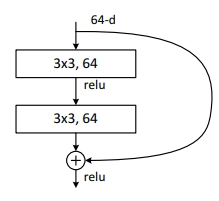

In [166]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, identity=None, stride=1):
        super(BasicBlock, self).__init__()
        
        self.residual = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * self.expansion)
        )
        
        self.relu = nn.ReLU()
        self.identity = identity

    def forward(self, x):
        out = self.residual(x)

        if self.identity is not None:
            skip_connection = self.identity(x)
        else:
            skip_connection = x

        out += skip_connection
        out = self.relu(out)
        return out

### Bottleneck

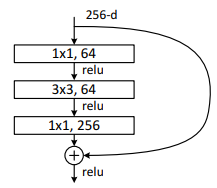

In [169]:
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, identity=None, stride=1):
        super(Bottleneck, self).__init__()
        
        self.residual = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels * self.expansion),
        )

        self.relu = nn.ReLU()
        self.identity = identity

    def forward(self, x):
        out = self.residual(x)

        if self.identity is not None:
            skip_connection = self.identity(x)
        else:
            skip_connection = x

        out += skip_connection
        out = self.relu(out)
        return out

### ResNet

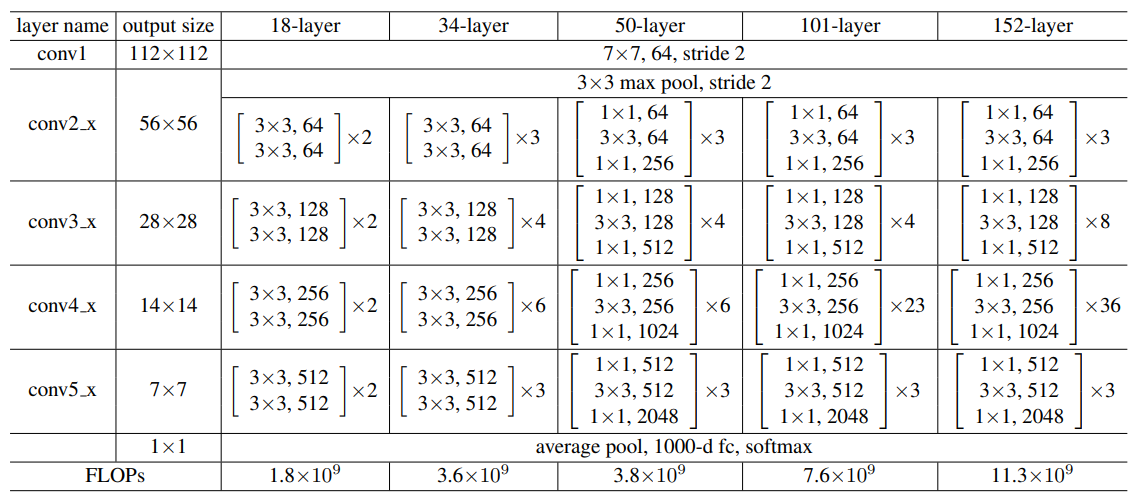

In [172]:
class ResNet(nn.Module):
    def __init__(self, block, layer, n_classes):
        super(ResNet, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=7, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.in_channels = 64
        self.layer1 = self.make_layer(block, layer[0], out_channels=64, stride=1)
        self.layer2 = self.make_layer(block, layer[1], out_channels=128, stride=2)
        self.layer3 = self.make_layer(block, layer[2], out_channels=256, stride=2)
        self.layer4 = self.make_layer(block, layer[3], out_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*block.expansion, n_classes)

    
    def make_layer(self, block, num_residual_blocks, out_channels, stride):
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            identity = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion)
            )
        else:
            identity = None

        layers = []
        for idx in range(num_residual_blocks):
            if idx == 0:
                layers.append(block(self.in_channels, out_channels, identity, stride))
                self.in_channels = out_channels * block.expansion
            else:
                layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    
    def forward(self, x):
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [174]:
def ResNet18(n_classes=1000):
    return ResNet(BasicBlock, [2,2,2,2], n_classes=n_classes)

def ResNet34(n_classes=1000):
    return ResNet(BasicBlock, [3,4,6,3], n_classes=n_classes)

def ResNet50(n_classes=1000):
    return ResNet(Bottleneck, [3,4,6,3], n_classes=n_classes)

def ResNet101(n_classes=1000):
    return ResNet(Bottleneck, [3,4,23,3], n_classes=n_classes)

def ResNet152(n_classes=1000):
    return ResNet(Bottleneck, [3,8,36,3], n_classes=n_classes)

In [176]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [178]:
resnet = ResNet34().to(device)
t = torchsummary.summary(resnet, (3,224,224), batch_size=2)
t

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [2, 64, 32, 32]           9,408
       BatchNorm2d-2            [2, 64, 32, 32]             128
              ReLU-3            [2, 64, 32, 32]               0
         MaxPool2d-4            [2, 64, 16, 16]               0
            Conv2d-5            [2, 64, 16, 16]          36,864
       BatchNorm2d-6            [2, 64, 16, 16]             128
              ReLU-7            [2, 64, 16, 16]               0
            Conv2d-8            [2, 64, 16, 16]          36,864
       BatchNorm2d-9            [2, 64, 16, 16]             128
             ReLU-10            [2, 64, 16, 16]               0
       BasicBlock-11            [2, 64, 16, 16]               0
           Conv2d-12            [2, 64, 16, 16]          36,864
      BatchNorm2d-13            [2, 64, 16, 16]             128
             ReLU-14            [2, 64,

In [180]:
resnet = ResNet101().to(device)
t = torchsummary.summary(resnet, (3,224,224), batch_size=2)
t

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [2, 64, 32, 32]           9,408
       BatchNorm2d-2            [2, 64, 32, 32]             128
              ReLU-3            [2, 64, 32, 32]               0
         MaxPool2d-4            [2, 64, 16, 16]               0
            Conv2d-5            [2, 64, 16, 16]           4,096
       BatchNorm2d-6            [2, 64, 16, 16]             128
              ReLU-7            [2, 64, 16, 16]               0
            Conv2d-8            [2, 64, 16, 16]          36,864
       BatchNorm2d-9            [2, 64, 16, 16]             128
             ReLU-10            [2, 64, 16, 16]               0
           Conv2d-11           [2, 256, 16, 16]          16,384
      BatchNorm2d-12           [2, 256, 16, 16]             512
           Conv2d-13           [2, 256, 16, 16]          16,384
      BatchNorm2d-14           [2, 256,